In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rapids-21.12


In [2]:
import sys

dir_github = r'/media/rich/Home_Linux_partition/github_repos/'
# sys.path.append('/n/data1/hms/neurobio/sabatini/rich/github_repos/')
sys.path.append(dir_github)

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

In [3]:
from pathlib import Path
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm.notebook import tqdm
from functools import partial

In [5]:
SYTdata1 = h5_handling.simple_load('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/ShihYi labeled_cells_for_Rich/trainingData_L5_171228.mat')
SYTdata2 = h5_handling.simple_load('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/ShihYi labeled_cells_for_Rich/trainingData_L23_171216.mat')

In [8]:
SYTmasks_list = [SYTdata1['alignedMasks'], SYTdata2['alignedMasks']]

In [12]:
import torch
import torchvision
def rescaler(list_of_images, scales):
    return [torchvision.transforms.functional.affine(img=torch.as_tensor(list_of_images[ii], dtype=torch.float32),
                                                                                     angle=0,
                                                                                     translate=[0,0],
                                                                                     scale=scales[ii],
                                                                                     shear=0,
                                                                                     interpolation=torchvision.transforms.InterpolationMode('bilinear'),
                                            #                                          fill: Optional[List[float]] = None
                                                                                    ) for ii in range(len(list_of_images))]

def padder(images, new_size, kwargs_center_crop={}):
    return torchvision.transforms.functional.center_crop(torch.as_tensor(images, dtype=torch.float32), output_size=new_size)

In [13]:
new_size = np.array([36, 36])

SYTmasks_list_36x36 = [padder(SYTmasks_list[ii], new_size).numpy() for ii in range(len(SYTmasks_list))]

scaling factors: [1.1115455  1.67833435]


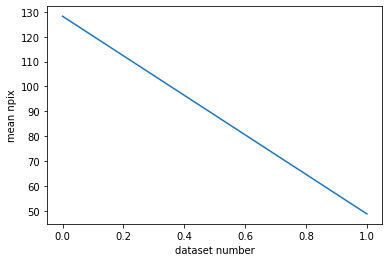

In [14]:
ROI_sizeMean, ROI_sizeStd = [], []

for ii in range(len(SYTmasks_list_36x36)):
    ROI_npix = np.sum(SYTmasks_list_36x36[ii]>0, axis=(1,2))
    ROI_sizeMean.append(np.mean(ROI_npix))
    ROI_sizeStd.append(np.std(ROI_npix))
    
%matplotlib inline
plt.figure()
plt.plot(ROI_sizeMean)
plt.xlabel('dataset number');
plt.ylabel('mean npix');

scale_factors = (((1/np.array(ROI_sizeMean))*200)**(1/2.35)) * 0.92
# scale_factors = 1 + ((175/np.array(ROI_sizeMean))**(1.25) -1)/6.5
# scale_factors = [1,1]
print(f'scaling factors: {scale_factors}')

In [15]:
SYTmasks_list_rescaled = rescaler(SYTmasks_list_36x36, scale_factors)
# SYTmasks_list_rescaled = rescaler(SYTmasks_list_36x36, [1.00001, 1.62])

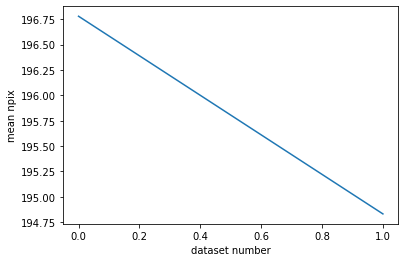

In [16]:
ROI_sizeMean, ROI_sizeStd = [], []

for ii in range(len(SYTmasks_list_rescaled)):
    ROI_npix = np.sum(SYTmasks_list_rescaled[ii].numpy()>0, axis=(1,2))
    ROI_sizeMean.append(np.mean(ROI_npix))
    ROI_sizeStd.append(np.std(ROI_npix))
    
%matplotlib inline
plt.figure()
plt.plot(ROI_sizeMean)
plt.xlabel('dataset number');
plt.ylabel('mean npix');

<IPython.core.display.Javascript object>


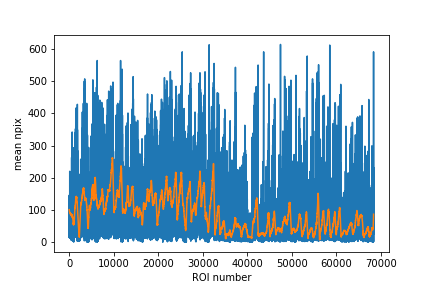

<IPython.core.display.Javascript object>


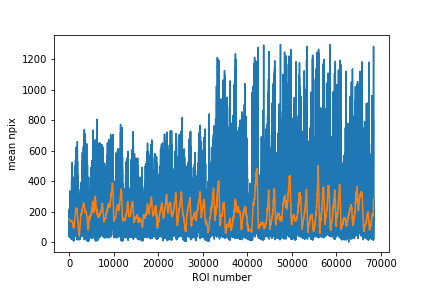

In [17]:
%matplotlib notebook

plt.figure()
plt.plot(np.sum(np.concatenate(SYTmasks_list_36x36) > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(np.concatenate(SYTmasks_list_36x36) > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

plt.figure()
plt.plot(np.sum(np.concatenate(SYTmasks_list_rescaled) > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(np.concatenate(SYTmasks_list_rescaled) > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

In [18]:
SYTmasks_list_rescaled_zeroSum = [SYTmasks_list_rescaled[ii] / torch.sum(SYTmasks_list_rescaled[ii], dim=(1,2))[:,None,None] for ii in range(len(SYTmasks_list_rescaled))]

In [19]:
# SYTmasks  = np.concatenate((SYTdata1['alignedMasks'], SYTdata2['alignedMasks']), axis=0)
SYTmasks_final  = np.concatenate(SYTmasks_list_rescaled_zeroSum, axis=0)
SYTlabels = np.concatenate((np.int64(SYTdata1['realLabels'][0]), np.int64(SYTdata2['realLabels'][0])), axis=0)

<IPython.core.display.Javascript object>


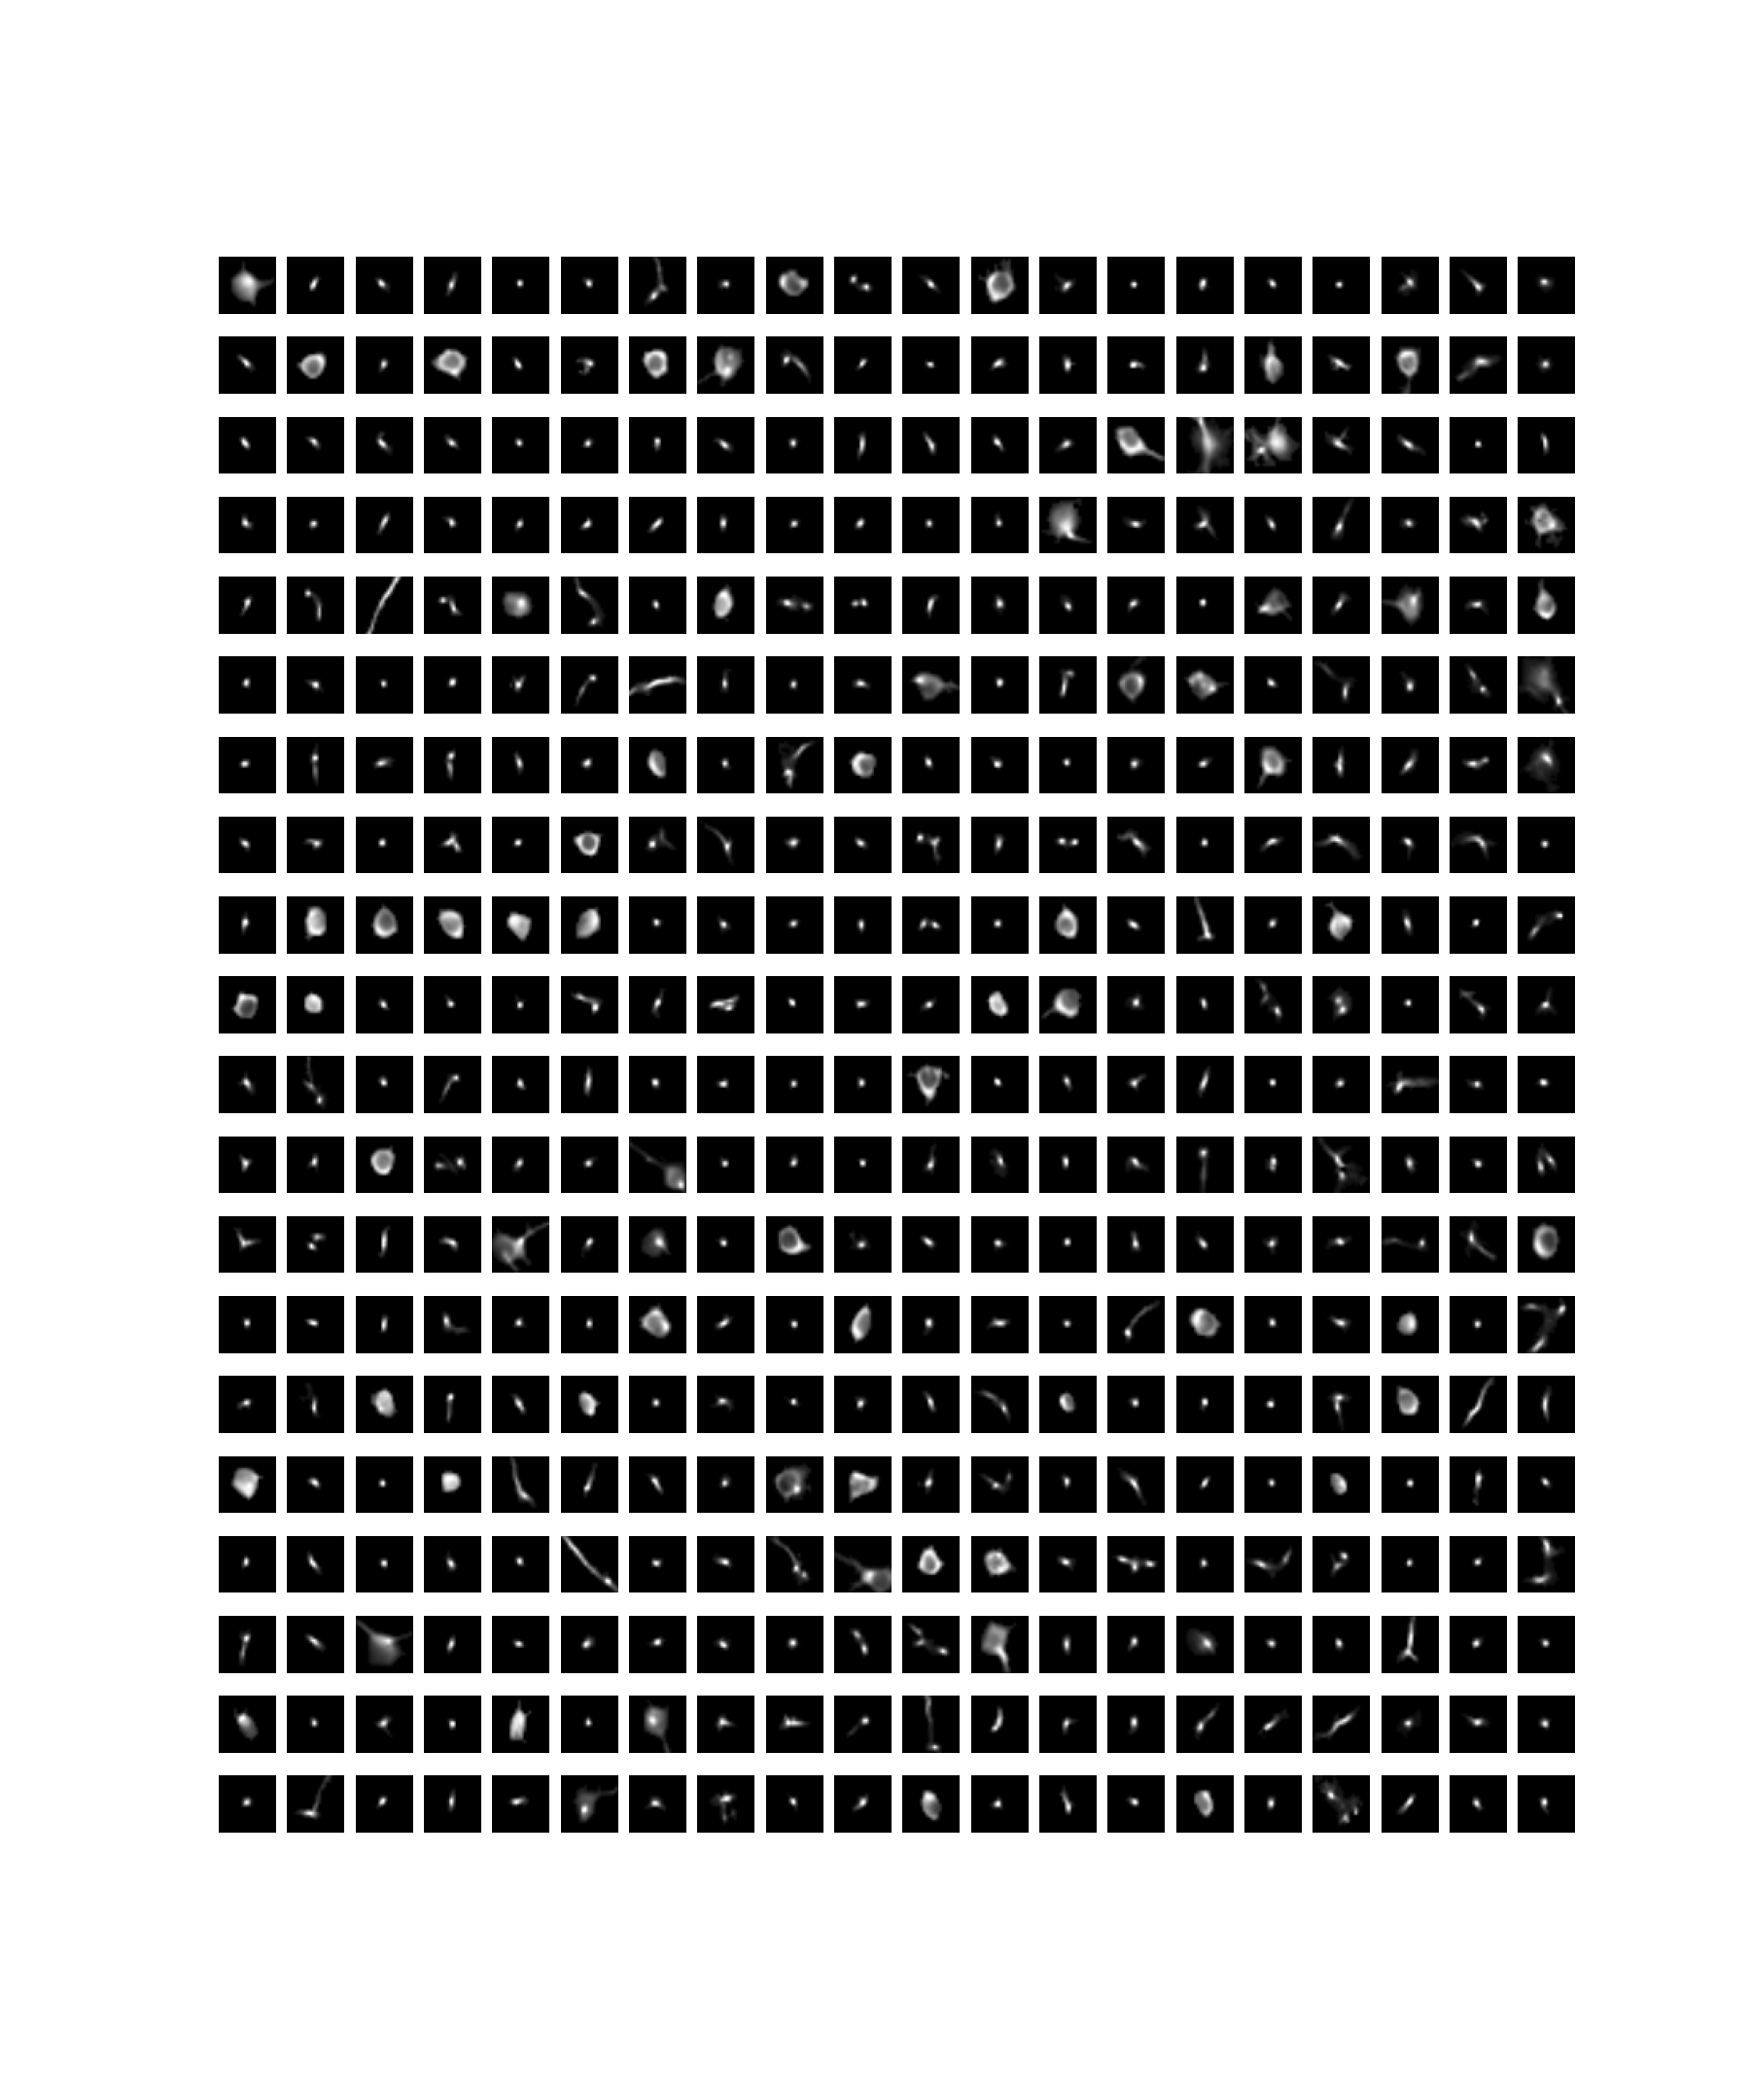

In [20]:
%matplotlib notebook
plotting_helpers.plot_image_grid(images=SYTmasks_list_rescaled_zeroSum[1][0:],
#                                 labels=SYTlabels[20000:],
                                grid_shape=(20,20),
                                show_axis='off',
                                cmap='gray',
                                kwargs_subplots={'figsize':(25,30)},
                                kwargs_imshow={'interpolation':'antialiased'});

## Saving

In [61]:
misc.estimate_array_size(sf_concat_rs)

1.196031744

In [23]:
SYTmasks_final.dtype

dtype('float32')

In [24]:
import scipy.sparse
import sparse

sf_concat_rs_sparse = scipy.sparse.csr_matrix(SYTmasks_final.reshape(SYTmasks_final.shape[0],-1))

scipy.sparse.save_npz('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/ShihYi labeled_cells_for_Rich/sf_concat_rs_sparse.npz', sf_concat_rs_sparse)

In [261]:
test = scipy.sparse.load_npz('/media/rich/bigSSD/other lab data/Packer_lab/sf_concat_rs_sparse.npz')

<IPython.core.display.Javascript object>


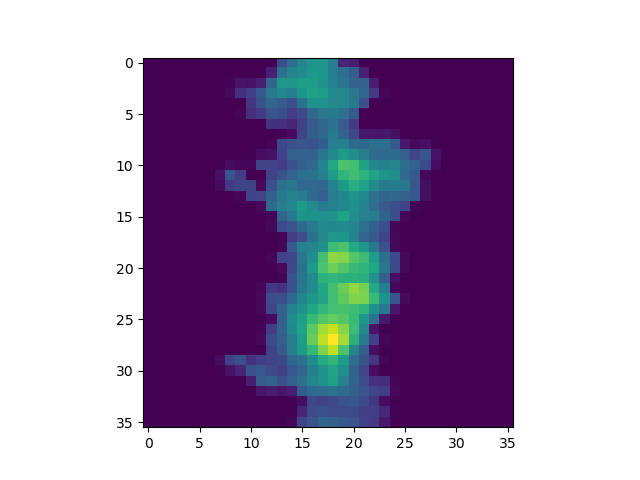

In [268]:
plt.figure()
plt.imshow(test[500000].toarray().reshape(36,36))